# Linear regression/ Least square fits

In [1]:
import pandas as pd
import numpy as np
import numpy.matlib as ml
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmocean
import scipy.io as sio
import scipy.interpolate as sciint
from scipy.stats import norm
import scipy 
import scipy.signal as sig
import seaborn as sns
import pylab as pl
import xarray as xr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import ffmpeg
from math import radians, cos, sin, asin, sqrt,log,floor
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Functions to load files

In [2]:
def get_Brink(file_fig,file_h): #, file_ratio):
    # Brink mode
    file = sio.loadmat(file_fig)
    z, xpl, xxx, zzz = file['z'][0,:], file['xpl'][0,:], file['xxx'][0,:], file['zzz'][0,:]
    k, omega = file['wavenumber'][0][0], file['frequency'][0][0]

    # (u is cross-shore and v is alongshore in Brink.)
    p0, u0, v0, w0, r0 = file['p'], file['u'],file['v'], file['wvel'], file['rho']

    #file_rfw = sio.loadmat(file_ratio)
    #R = file_rfw['ratio_for_wave'][0][0]
    #print('ratio for wave', R)
    #print('k (rad/cm) ', k)
    #print('lambda (km) ', ((2*np.pi)/(k*100))*1E-3)
    #print('omega (rad/s) ', omega)
    #print('period (days)', ((2*np.pi)/omega)/(3600*24))
    #print('c (m/s)', (omega/(k*100)))
    scale=0.2
    w = w0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization (?)
    u = u0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization 
    v = v0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization 
    r = r0.transpose() * 1.0 * scale # mg/cm³ to kg/m³ and normalization
    p = p0.transpose() * 0.1 * scale # dyn/cm² to 0.1 Pa (or kg m-1 s-2) and normalization
    
    hfile=sio.loadmat(file_h)
    h=hfile['h']
    
    nn=np.size(h)+2
    mm=np.size(h)+2
    xgr = np.zeros((nn-2,mm-2))
    zgr =  np.zeros((nn-2,mm-2))
    xmax=max(xpl)
    xmax = xmax*1.0e05
    dt = 1/(mm-3)
    dx = xmax/(nn-3)
    for n in np.arange(0,nn-2,1):
        xtemp = dx*n
        xgr[n,:] = (xtemp*np.ones(mm-2))/1e5
        zgr[n,:] = h[0,n]*(-1+dt*np.arange(0,mm-2,1))/100
    
    #z[0:-1]=-np.log10(-z[0:-1])
    #zzz=-np.log10(-zzz)
    return(u,v,w,r,p,z,k,omega,xpl, xxx, zzz,zgr.transpose(),xgr.transpose(),h)

def loadNetCDFs(varname):
    dsw=[]
    dsn=[]
    for i in np.arange(0,8,1):
        
        if varname=='DYNVARS':
            pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
            pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        else:
            pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01b_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
            pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01b_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        
        dswin  = xr.open_dataset(pathw)
        dsnin = xr.open_dataset(pathn)
        
        dsw.append(dswin)
        dsn.append(dsnin)
        
    return dsw, dsn

# Plot

In [3]:
def LINREGplot(fig,ax0,ax1,ax2,ax3,ax4,ax5,VALMITp,VALFITp,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,TIME,BETAp,FITp,t,rmse):
    gs = GridSpec(nrows=3, ncols=2, height_ratios=[1,1,1])
    xlab='Crosshore distance [km]'
    ylab='Depth [m]'


    depths=np.arange(71,0,-1)
    vmin=-np.max(abs(VALMITp[t,:,:]))
    vmax=np.max(abs(VALMITp[t,:,:]))

    levels=np.linspace(vmin,vmax,15)
    
    vminb=-np.max(abs(varbrink1[:,:]))
    vmaxb=np.max(abs(varbrink1[:,:]))

    levelsb=np.linspace(vminb,vmaxb,15)

    hFacC = dsw[0].hFacC
    hfac = np.ma.masked_values(hFacC, 0)
    mask = np.ma.getmask(hfac)
    masky=mask[depths,ind,:]
    coast=np.where(mask[0,ind,:]==False)

    LON = dsw[0].XC[coast]-360

    distance=cos((lat*np.pi)/180)*111*-1*(LON-LON[-1])
    
    if lat>32:
        indlonpre=np.where(distance<=80)
    else:
        indlonpre=np.where(distance<=99)
        
    indlon=np.flip(indlonpre[0])

    
    ax0.set_facecolor('tan')
    cax=ax0.contourf(dist,Z,np.ma.masked_array(VALFITp[t,:,:],mask=masky[:,indlon]),cmap=cmocean.cm.delta,levels=levels)
    ax0.contour(dist,Z,np.ma.masked_array(VALFITp[t,:,:],mask=masky[:,indlon]), levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax0.set(xlabel=xlab, ylabel=ylab)
    ax0.set_title('Linear regression fit')

    
    ax1.set_facecolor('tan')
    cax3=ax1.contourf(dist,Z,np.ma.masked_array(VALMITp[t,:,:],mask=masky[:,indlon]),cmap=cmocean.cm.delta,levels=levels)
    ax1.contour(dist, Z,np.ma.masked_array(VALMITp[t,:,:],mask=masky[:,indlon]), levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax1.set(xlabel=xlab, ylabel=ylab)
    ax1.set_title('MITgcm')


    ax2.set_facecolor('tan')
    ax2.contourf(dist,Z,np.ma.masked_array(varbrink1,mask=masky[:,indlon]),cmap=cmocean.cm.delta,levels=levelsb)
    ax2.contour(dist,Z,np.ma.masked_array(varbrink1,mask=masky[:,indlon]), levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax2.set(xlabel=xlab, ylabel=ylab)
    ax2.set_title('Brink mode 1')
    ax2.set_ylim([-1000,0])

    
    ax3.set_facecolor('tan')
    ax3.contourf(dist,Z,np.ma.masked_array(varbrink2,mask=masky[:,indlon]),cmap=cmocean.cm.delta,levels=levelsb)
    ax3.contour(dist,Z,np.ma.masked_array(varbrink2,mask=masky[:,indlon]), levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax3.set(xlabel=xlab, ylabel=ylab)
    ax3.set_title('Brink mode 2')
    ax3.set_ylim([-1000,0])

    
    ax4.set_facecolor('tan')
    ax4.contourf(dist,Z,np.ma.masked_array(varbrink3,mask=masky[:,indlon]),cmap=cmocean.cm.delta,levels=levelsb)
    ax4.contour(dist,Z,np.ma.masked_array(varbrink3,mask=masky[:,indlon]), levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax4.set(xlabel=xlab, ylabel=ylab)
    ax4.set_title('Brink mode 3')
    ax4.set_ylim([-1000,0])


    ax5.set_facecolor('tan')
    cax2=ax5.contourf(dist,Z,np.ma.masked_array(varbrink4,mask=masky[:,indlon]),cmap=cmocean.cm.delta,levels=levelsb)
    ax5.contour(dist,Z,np.ma.masked_array(varbrink4,mask=masky[:,indlon]), levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax5.set(xlabel=xlab, ylabel=ylab)
    ax5.set_ylim([-1000,0])
    ax5.set_title('Brink mode 4')

    cbar_ax = fig.add_axes([1, 0.675, 0.03, 0.2])
    fig.colorbar(cax, cax=cbar_ax)
    cbar_ax.set_ylabel('Pressure')
    cbar_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    
    cbar_ax2 = fig.add_axes([1, 0.13, 0.03, 0.4])
    fig.colorbar(cax2, cax=cbar_ax2)
    cbar_ax2.set_ylabel('Pressure')
    cbar_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    
    fig.suptitle(f'Regression line: Y = {BETAp[t,0]:.2e} + {BETAp[t,1]:.2e}X1+ {BETAp[t,2]:.2e}X2 + {BETAp[t,3]:.2e}X3+ {BETAp[t,4]:.2e}X4 \n At {lat}°N. After {TIME[t]/(60*24):.1f} days. Fit: {FITp[t]:.1f} %. RMSE:{rmse:.6f} ')
    fig.tight_layout()

## Interpolation

In [4]:
def interpolate(VALmit,VALbrink1,VALbrink2,VALbrink3,VALbrink4,dist,xpl,Z,z,zgr,xgr,indlon,mask):
    
    valbrinkin1=VALbrink1
    valbrinkin2=VALbrink2
    valbrinkin3=VALbrink3
    valbrinkin4=VALbrink4
    
    #finding the coordinates for all points in the brink variable
    zpib,xpib=np.where(valbrinkin1<100)
    
    #picking out the values using the coordinates and creating a 1D vector
    valbrink1d1=valbrinkin1[zpib,xpib]
    valbrink1d2=valbrinkin2[zpib,xpib]
    valbrink1d3=valbrinkin3[zpib,xpib]
    valbrink1d4=valbrinkin4[zpib,xpib]
    
    # go back to 2D
    # valmit2d = np.zeros(np.shape(VALmit))
    #for i in np.arange(len(valmitout)):
    #    valmit2d[zpi[i],xpi[i]]=valmitout[i]
    
    #Creating a grid of Z which does not include the values in the coast, similar to the grid from Brink
    grid_Z=np.zeros(np.shape(VALmit))
    for i in np.arange(0,len(indlon),1):

        coastz=np.where(mask[:,indlon[i]]==False) #finding the indices of the coast at one x-location
        if len(Z[coastz])>0:
            places=np.arange(0,71,71/len(Z[coastz]))  #creating a vector of the same size as how many 
                                                        #depth values we have that aren't the coast 
            if len(places)> len(Z[coastz]):           #Sometimes the vector became too long
                places=places[:-1] 
            places[-1]=71                           #making sure the last value in the vector of indices 
            #is 71 so we interpolate over the same start and finish vaues
            grid_Z[:,i]=np.interp(np.arange(0,71,1),places,Z[coastz]) #Interpolating the values that arent the coast
            # to agree with the amount of depth values the
                        
                                                                  # the model outputs. Using the range of indices
                                                                  #given from the vector created to show indices
                                                                  # that the depth values not on the coast correspond to
                                                                  # and then fillign the rest with values between these.

    #Creating a grid of the x-values, which are the same for every Z
    grid_X,grid_no = np.meshgrid(dist,Z)
    
    
    points=[zgr[zpib,xpib],xgr[zpib,xpib]] #find the depth and distance for each of the indices in the Brink code
    points=np.asarray(points).transpose()  #transposing this to so the values are the columns and not the rows for the interpolation
    valbrinkout1 = sciint.griddata(points, valbrink1d1, (grid_Z, grid_X), method='linear')
    valbrinkout2 = sciint.griddata(points, valbrink1d2, (grid_Z, grid_X), method='linear')
    valbrinkout3 = sciint.griddata(points, valbrink1d3, (grid_Z, grid_X), method='linear')
    valbrinkout4 = sciint.griddata(points, valbrink1d4, (grid_Z, grid_X), method='linear')
    
    zpi,xpi=np.where(mask[:,indlon]==False)
    #zpi,xpi=np.where(~np.isnan(valbrinkout1))
    
    x1= valbrinkout1[zpi,xpi]
    x2= valbrinkout2[zpi,xpi]
    x3= valbrinkout3[zpi,xpi]
    x4= valbrinkout4[zpi,xpi]
        
    valmit1d= VALmit[zpi,xpi]
    
    
    return valmit1d,x1,x2,x3,x4,xpi,zpi,valbrinkout1,valbrinkout2,valbrinkout3,valbrinkout4,grid_X,grid_Z,zpi,xpi

## Not using this (To make R and P according to Red tide)

In [11]:
def R_make(X,Ypre,t,filename):
    #Calculate the variance of the Beta
    ds = xr.open_dataset(filename)
    betas=ds.betas[t,:].values
    #Nb=len(betas)
    #normB=(betas)-np.mean(betas)
    #sigmaS= np.mean(np.matmul(normB.T,normB))/Nb
    #Calculating the residuals
    Yfit=X.dot(betas) + np.mean(Ypre)
    
    res=Ypre-Yfit
    N=len(res)
    m=np.mean(res)
    var=((res-m)**2)/N
    varstand=var-np.mean(var)/np.std(var)
    #Creating R matrix to reduce the error in the best way
    R=np.diag(var)
    
    return R

def P_make():
    
    P=np.identity(5) #*0.9 #*1e2 #sigmaS
    P[0,:]=P[0,:]*1 #10**(-floor(log(np.matmul(X.T,Xnd)[0,0],10)))*betas[0]*10**(-floor(log(abs(betas[0]),10)))  
    P[1,:]=P[1,:]*1e-11 #10**(-floor(log(np.matmul(X.T,Xnd)[1,1],10)))*betas[1]*10**(-floor(log(abs(betas[1]),10)))  
    P[2,:]=P[2,:]*1e-5 #10**(-floor(log(np.matmul(X.T,Xnd)[2,2],10)))*betas[2]*10**(-floor(log(abs(betas[2]),10)))  
    P[3,:]=P[3,:]*1e-5 #10**(-floor(log(np.matmul(X.T,Xnd)[3,3],10)))*betas[3]*10**(-floor(log(abs(betas[3]),10))) 
    P[4,:]=P[4,:]*1e-5 #10**(-floor(log(np.matmul(X.T,Xnd)[4,4],10)))*betas[4]*10**(-floor(log(abs(betas[4]),10)))  
    Pout=P/np.std(P)
    return P
    

## lin_reg is where the regression happens, fitmodes is to adjust the MITgcm data according to time step and distance from the coast for different latitudes

In [12]:
def lin_reg(VALmit,VALbrink1,VALbrink2,VALbrink3,VALbrink4,dist,xpl,Z,z,zgr,xgr,indlon,maskin,typ,t,filename):
    
    #Interpolating the data and unraveling it to 1D
    Ypre,x1,x2,x3,x4,xpi,zpi,varbrink1out,varbrink2out,varbrink3out,varbrink4out,grid_X,grid_Z,zpi,xpi=interpolate(VALmit,VALbrink1,VALbrink2,
                                                                             VALbrink3,VALbrink4,dist,xpl,
                                                                              Z,z,zgr,xgr,indlon,maskin)
    #Normalizing the Y vector to have a zero mean
    Y=Ypre-np.mean(Ypre)
    Yin=Y
    #Creating a matrix with the modes as the columns 
    X=np.vstack((np.ones(len(x1)),x1, x2,x3,x4)).T
    
    
    R=R_make(X,Ypre,t,filename)
    P=P_make()
    
    Ynd=np.matmul(np.linalg.inv(R),Y)
    Xnd=np.matmul(np.linalg.inv(R),X)
    
    #NON-NONDIMENSIONALISED
    Xinv= np.matmul(X.T,Xnd) + np.linalg.inv(P)
    
    beta_hat = np.matmul(np.matmul(np.linalg.inv(Xinv),X.T),Ynd)
        
    #NON-DIMENSIONALISED
   #yw=np.matmul(np.diag(R[R!=0]**(-1/2)),Y)
    #xw=np.matmul(np.diag(R[R!=0]**(-1/2)),X)
    #xprime=np.matmul(xw,P**(1/2))

   # xnd=np.matmul(xprime.T,xprime)+np.identity(5)
    #xynd=np.matmul(xprime.T,yw)
    #beta_hat=np.matmul(np.matmul(P**(1/2),np.linalg.inv(xnd)),xynd)  
    
    yhat=X.dot(beta_hat)+np.mean(Ypre)
    
    valout = np.zeros(np.shape(VALmit))
    valmit2d = np.zeros(np.shape(VALmit))
    varbrink1 = np.zeros(np.shape(VALmit))
    varbrink2 = np.zeros(np.shape(VALmit))
    varbrink3 = np.zeros(np.shape(VALmit))
    varbrink4 = np.zeros(np.shape(VALmit))
    
    for i in np.arange(len(Y)):
        valout[zpi[i],xpi[i]]=yhat[i]
        varbrink1[zpi[i],xpi[i]]=x1[i]
        varbrink2[zpi[i],xpi[i]]=x2[i]
        varbrink3[zpi[i],xpi[i]]=x3[i]
        varbrink4[zpi[i],xpi[i]]=x4[i]
        valmit2d[zpi[i],xpi[i]]=Ypre[i]

    return beta_hat,yhat,X,Y,valout,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,P,R,xpi,zpi,valmit2d,Ypre

def fitmodes(dsw,dsn,tt,VALbrink1,VALbrink2,VALbrink3,VALbrink4,xpl,Z,z,ind,lon,h,zgr,xgr,typ,filt,ds,filename):
    
    hFacC = dsw[0].hFacC
    hfac = np.ma.masked_values(hFacC, 0)
    mask = np.ma.getmask(hfac)
    
    coast=np.where(mask[0,ind,:]==False)
    
    LON = dsw[0].XC[coast]-360

    distance=cos((lat*np.pi)/180)*111*-1*(LON-LON[-1])
    if lat>32:
        indlonpre=np.where(distance<=80)
    else:
        indlonpre=np.where(distance<=99)
    indlon=np.flip(indlonpre[0])
    #actual distance from the coast
    distpre=distance[indlon]
    dist=distpre
    
    depths=np.arange(71,0,-1)
    maskin=mask[depths,ind,:]
    if filt==0:
        VALMIT=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1]),71,len(dist)))
        VALfit=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1]),71,len(dist)))
        #VALfit=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1]),len(VALbrink1[1,:]),len(VALbrink1[1,:])))
        betas=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1]),5))
        fit=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1])))
        RMSE=np.zeros((len(dsw[tt].PHIHYD[:,1,1,1])))
        for t in np.arange(0,len(dsw[tt].PHIHYD[:,1,1,1]),1):
            VALb=dsw[tt].PHIHYD[t,depths,ind,indlon].values
            VALn=dsn[tt].PHIHYD[t,depths,ind,indlon].values
            VALmit=VALb-VALn
            beta_hat,yhat,xbeta, Y,valout,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,P,R,xpi,zpi,valmit2d,Ypre=lin_reg(VALmit,VALbrink1,
                                                                                                                                  VALbrink2,VALbrink3,VALbrink4,dist,xpl,Z,z,zgr,xgr,indlon,maskin,typ,t,filename)
            VALfit[t,:,:]=valout
            betas[t,:]=beta_hat
            VALMIT[t,:,:]=VALmit

            mse=np.mean((Ypre - yhat) ** 2)
            rmse=sqrt(mse)
            RMSE[t]=rmse

            yi=VALmit
            sst=np.sum((yi-np.mean(yi))**2)
            yihat=valout
            ssr=np.sum((yihat-np.mean(yihat))**2)
            fit[t]=100*(ssr/sst)
    else:
        VALMIT=np.zeros((len(ds.VALfilt[:,1,1]),71,len(dist)))
        VALfit=np.zeros((len(ds.VALfilt[:,1,1]),71,len(dist)))
        betas=np.zeros((len(ds.VALfilt[:,1,1]),5))
        fit=np.zeros((len(ds.VALfilt[:,1,1])))
        RMSE=np.zeros((len(ds.VALfilt[:,1,1])))
        for t in np.arange(100,101,1): #np.arange(0,len(ds.VALfilt[:,1,1]),1):
            VALmit=ds.VALfilt[t,:,:].values
            beta_hat,yhat,xbeta, Y,valout,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,P,R,xpi,zpi,valmit2d,Ypre=lin_reg(VALmit,VALbrink1,
                                              VALbrink2,VALbrink3,VALbrink4,dist,xpl,Z,z,zgr,xgr,indlon,maskin,typ,t,filename)
            VALfit[t,:,:]=valout
            betas[t,:]=beta_hat
            VALMIT[t,:,:]=valmit2d
            
            mse=np.mean((Ypre - yhat) ** 2)
            rmse=sqrt(mse)
            RMSE[t]=rmse
            
            yi=VALmit
            sst=np.sum((yi-np.mean(yi))**2)
            yihat=valout
            ssr=np.sum((yihat-np.mean(yihat))**2)
            fit[t]=100*(ssr/sst)   
    
    return VALfit,betas,xbeta,yhat,dist,VALMIT,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,fit,Y,P,R,xpi,zpi,Ypre,RMSE


In [7]:
u,v1,w1,r,p1,z,k,omega,xpl, xxx, zzz, zgr, xgr, h = get_Brink('dataSVB30.84mode1.mat','h30.84.mat')
u,v2,w2,r,p2,z,k,omega,xpl, xxx, zzz, zgr, xgr, h = get_Brink('dataSVB30.84mode2.mat','h30.84.mat')
u,v3,w3,r,p3,z,k,omega,xpl, xxx, zzz, zgr, xgr, h = get_Brink('dataSVB30.84mode3.mat','h30.84.mat')
u,v4,w4,r,p4,z,k,omega,xpl, xxx, zzz, zgr, xgr, h = get_Brink('dataSVB30.84mode4.mat','h30.84.mat')

In [8]:
dsw,dsn=loadNetCDFs('PHIHYD')

In [9]:
varname='WVEL'
i=1
pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'ACnoSVBdep55'+ str(2+i)+'_'+ str(3+i) +'all.nc'
ds1 = xr.open_dataset(pathn)
lon_ac=ds1.lonAC
lat_ac=ds1.latAC
distac=ds1.x

In [14]:
Xnd=np.matmul(np.linalg.inv(R),xbeta)
np.matmul(xbeta.T,Xnd)

array([[ 2.24224093e+20,  3.49727626e+11, -7.60089624e+12,
        -1.68496112e+13,  1.97313330e+12],
       [ 3.49727626e+11,  6.91472049e+05,  1.72182471e+05,
         4.04071633e+03, -9.28144204e+04],
       [-7.60089624e+12,  1.72182471e+05,  4.63459238e+05,
         6.60280547e+05, -4.42589830e+04],
       [-1.68496112e+13,  4.04071633e+03,  6.60280547e+05,
         1.36299836e+06, -1.19247417e+05],
       [ 1.97313330e+12, -9.28144204e+04, -4.42589830e+04,
        -1.19247417e+05,  5.29798075e+04]])

In [43]:
ds = xr.open_dataset('LinReg3084FILT.nc')
betas=ds.betas[t,:].values
 
Yfit=xbeta.dot(betas) + np.mean(Ypre)
res=Ypre-Yfit

## Running the regression for filtered data

In [13]:
hej=[58, 85, 205, 227] #use one of these indices to create pressure plots in order: 30.84,31.20,32.68,32.98°N
tt=0
ind=lat_ac[58]
lat=30.84 #remember that all larger than 32 will be for only 80 km from the coast. 
depths=np.arange(71,0,-1)
Z=dsw[0].Zl[depths].values
typ='white'
ds=xr.open_dataset('PHIHYD3084filt.nc')
filename='LinReg3084FILT.nc'
filt=1

VALfit,betas,xbeta,yhat,dist,VALmit,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,fit,Y,P,R,xpi,zpi,Ypre,RMSE=fitmodes(dsw,dsn,tt,p1,p2,p3,p4,xpl,Z,z,ind,lat,h,zgr,xgr,typ,filt,ds,filename)
  

In [71]:
yhat=xbeta.dot(beta)+np.mean(Ypre)

## Running the regression for unfiltered data

In [101]:
ind=lat_ac[58]
lat=30.84
depths=np.arange(71,0,-1)
Z=dsw[0].Zl[depths].values
t=0
filt=0

VALFITp=np.zeros((72*5+144*3,np.size(VALmit[1,:,0]),np.size(VALmit[1,0,:])))
VALMITp=np.zeros((72*5+144*3,np.size(VALmit[1,:,0]),np.size(VALmit[1,0,:])))
FITp=np.zeros((72*5+144*3))
RMSEp=np.zeros((72*5+144*3))
BETAp=np.zeros((72*5+144*3,5))
for tt in np.arange(0,8,1):
    VALfitorg,betasorg,xbetaorg,yhatorg,dist,VALmitorg,varbrink1,varbrink2,varbrink3,varbrink4,grid_X,grid_Z,fitorg,Yorg,P,R,xpi,zpi,Ypreorg,rmseorg=fitmodes(dsw,dsn,tt,p1,p2,p3,p4,xpl,Z,z,ind,lat,h,zgr,xgr,typ,filt,ds)
    if tt<=2:
        VALFITp[len(dsw[tt-1].PHIHYD[:,1,1])*tt:len(VALfitorg[:,1,1])*(tt+1),:,:]=VALfitorg
        VALMITp[len(dsw[tt-1].PHIHYD[:,1,1])*tt:len(VALfitorg[:,1,1])*(tt+1),:,:]=VALmitorg
        FITp[len(dsw[tt-1].PHIHYD[:,1,1])*tt:len(VALfitorg[:,1,1])*(tt+1)]=fitorg
        BETAp[len(dsw[tt-1].PHIHYD[:,1,1])*tt:len(VALfitorg[:,1,1])*(tt+1),:]=betasorg
        RMSEp[len(dsw[tt-1].PHIHYD[:,1,1])*tt:len(VALfitorg[:,1,1])*(tt+1)]=rmseorg
    else:
        VALFITp[432+len(VALfitorg)*(tt-3):432+len(VALfitorg[:,1,1])*(tt-2),:,:]=VALfitorg
        VALMITp[432+len(VALfitorg)*(tt-3):432+len(VALfitorg[:,1,1])*(tt-2),:,:]=VALmitorg
        FITp[432+len(VALfitorg)*(tt-3):432+len(VALfitorg[:,1,1])*(tt-2)]=fitorg
        BETAp[432+len(VALfitorg)*(tt-3):432+len(VALfitorg[:,1,1])*(tt-2),:]=betasorg
        RMSEp[432+len(VALfitorg)*(tt-3):432+len(VALfitorg[:,1,1])*(tt-2)]=rmseorg

## Trade off curve

In [158]:
rescostpl=[]
parcostpl=[]
rmsepl=[]

In [411]:
mse=np.mean((Ypre - yhat) ** 2)
rmse=sqrt(mse)
rmsepl=np.append(rmsepl,rmse)

In [412]:
rescost=np.matmul(np.matmul((Ypre-yhat).T,np.linalg.inv(R)),(Ypre-yhat))
rescostpl=np.append(rescostpl,rescost)

In [413]:
parcost=np.matmul(np.matmul(betas[0,:].T,np.linalg.inv(P)),betas[0,:])
parcostpl=np.append(parcostpl,parcost)

In [414]:
print(rescostpl)
print(parcostpl)
print(rmsepl)

[2.83354890e-09 9.98269395e-10 1.03731776e-09 1.01116481e-09
 1.08177994e-09 8.99882149e-10 8.94572254e-10 8.94374047e-10
 8.94323328e-10 8.94318262e-10 4.55401234e-09 9.00030370e-10
 8.58233376e-10 8.59328385e-10 8.59206616e-10 1.04232664e-09
 5.11932993e-01 3.64930521e-03]
[ 1.08215203e-09  6.98605179e-10  7.92265875e-10  8.89833447e-10
  1.00119159e-09  3.66473446e-10  3.14261052e-10  3.12081886e-10
  3.11520989e-10  3.11464887e-10 -2.34752979e-09  2.66279488e-10
  4.87115766e-11 -5.60919266e-12 -6.19065742e-12  3.32836262e-10
 -5.18752244e-01  3.17551869e-03]
[1.11485391e-04 9.92514171e-05 9.93457694e-05 9.92032346e-05
 9.97991896e-05 9.87457284e-05 9.87135708e-05 9.87123617e-05
 9.87120523e-05 9.87120213e-05 1.49351476e-04 9.86027913e-05
 9.84639778e-05 9.84382936e-05 9.84374876e-05 1.01150831e-04
 1.08046624e-03 1.09421894e-04]


[Text(0.5, 0, 'x.T P^{-1} x'), Text(0, 0.5, '(Y-Hx).T R^{-1}(Y-Hx)')]

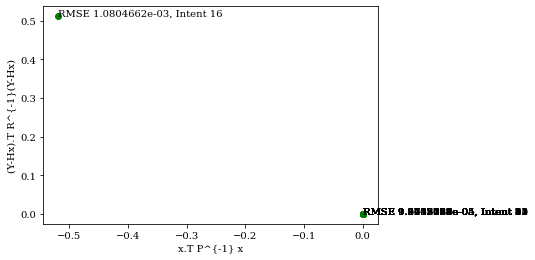

In [405]:
fig,ax=plt.subplots()
for k in np.arange(len(parcostpl)):
    ax.plot(parcostpl[k],rescostpl[k],'go')
    ax.annotate(f'RMSE {rmsepl[k]:.7e}, Intent {k}',(parcostpl[k],rescostpl[k]))


ax.set(xlabel='x.T P^{-1} x', ylabel='(Y-Hx).T R^{-1}(Y-Hx)')


In [233]:
rmsepl=np.delete(rmsepl,len(rmsepl)-1)
parcostpl=np.delete(parcostpl,len(parcostpl)-1)
rescostpl=np.delete(rescostpl,len(rescostpl)-1)

## Loading the times

In [16]:
time23=dsw[0].time.values.astype(int)
time34=dsw[1].time.values.astype(int)
time45=dsw[2].time.values.astype(int)
time56=dsw[3].time.values.astype(int)
time67=dsw[4].time.values.astype(int)
time78=dsw[5].time.values.astype(int)
time89=dsw[6].time.values.astype(int)
time910=dsw[7].time.values.astype(int)
    
Time=np.concatenate((time23, time34, time45, time56,time67, time78,time89, time910), axis=0)#, time910), axis=0)
    
times=Time*1e-9
  

## Visualising the fit

In [11]:
dsFILT=xr.open_dataset('WRLinReg3084FILTR1.nc')

In [12]:
VALmit=dsFILT.valmit.values
VALfit=dsFILT.valfit.values
varbrink1=dsFILT.varbrink1.values
varbrink2=dsFILT.varbrink2.values
varbrink3=dsFILT.varbrink3.values
varbrink4=dsFILT.varbrink4.values
dist=dsFILT.x.values
Z=dsFILT.z.values
betas=dsFILT.betas.values
fit=dsFILT.fit.values
rmse=dsFILT.rmse.values
grid_Z=dsFILT.gridZ.values
grid_X=dsFILT.gridX.values

In [18]:
params = {'font.size': 26,
          'figure.figsize': (20, 17),
         'font.family':'serif'}
pl.rcParams.update(params)

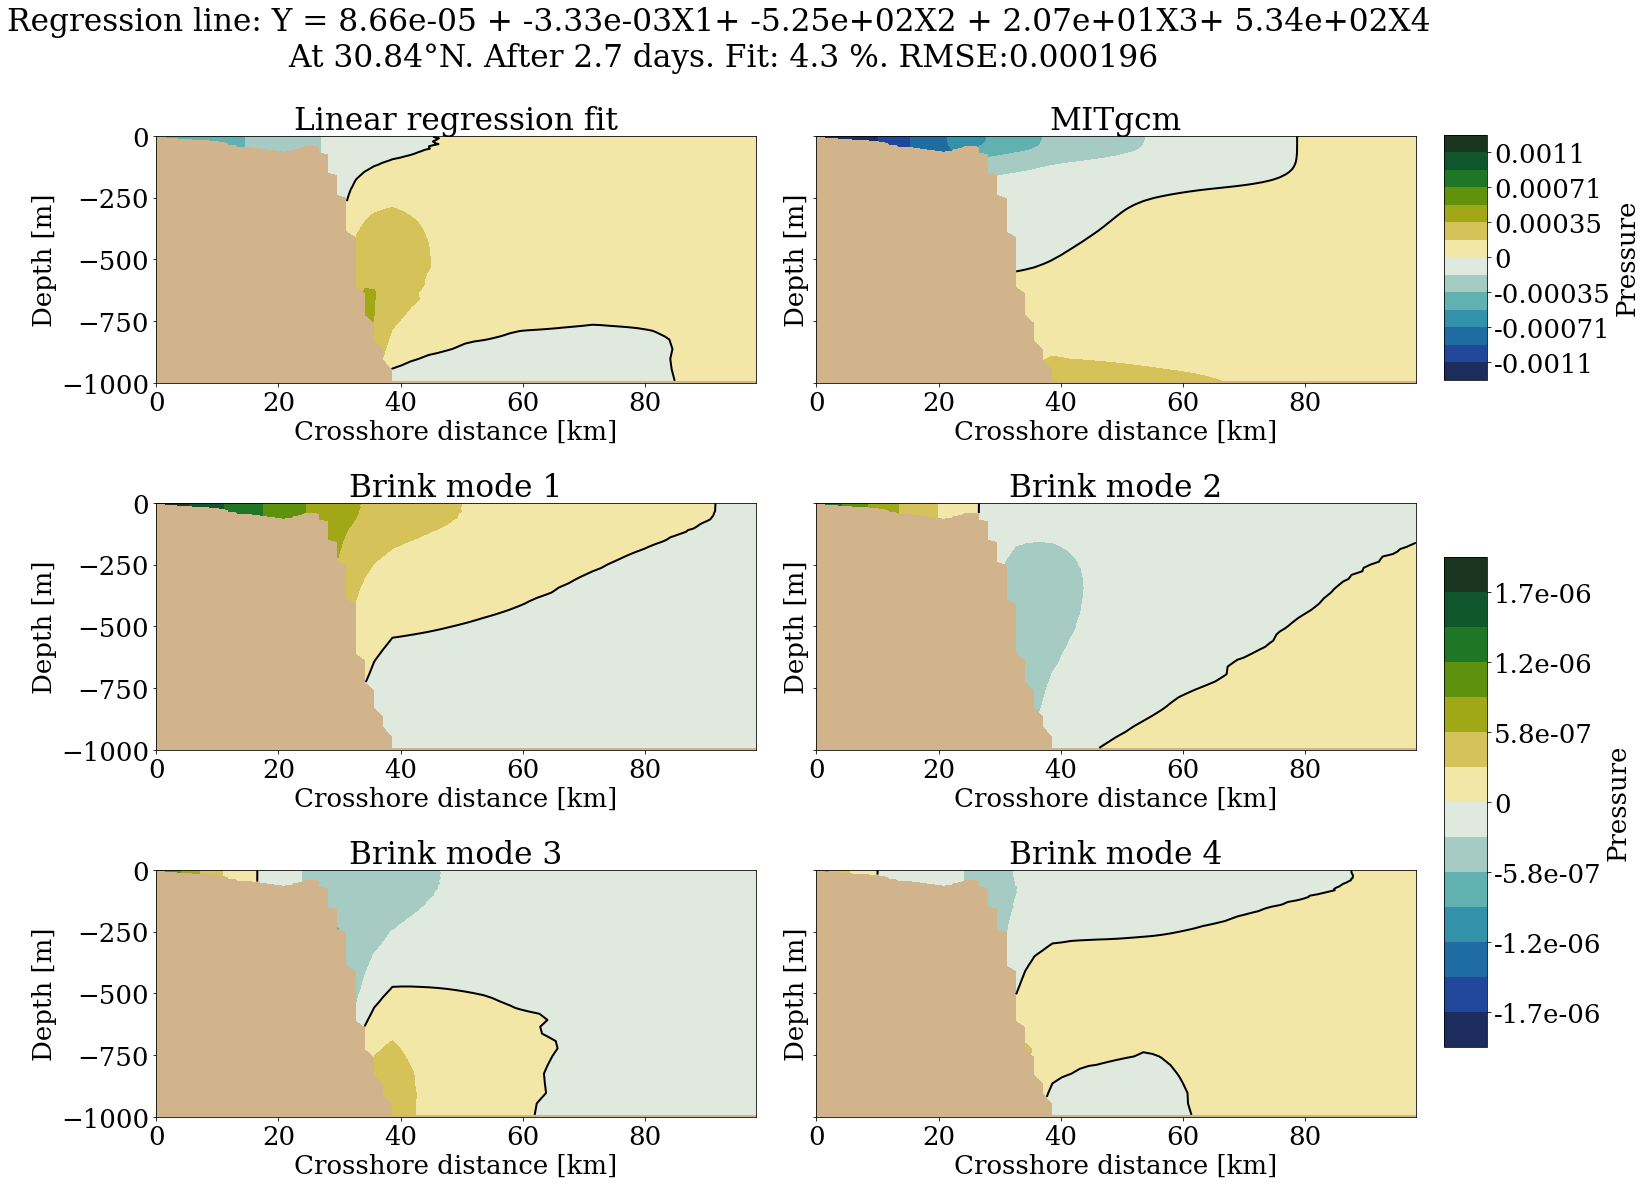

In [19]:
ind=lat_ac[58]
lat=30.84
t=100#np.argmax(RMSE)
fig,ax = plt.subplots(3,2,sharey=True)
LINREGplot(fig,ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1],VALmit,VALfit,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,times,betas,fit,t,RMSE[t])

In [21]:
res=VALmit-VALfit

In [34]:
var

array([[[1.69120613e-31, 1.69120613e-31, 1.69120613e-31, ...,
         1.77232254e-23, 1.69829413e-23, 1.64020480e-23],
        [1.69120613e-31, 1.69120613e-31, 1.69120613e-31, ...,
         1.38801359e-23, 1.37246554e-23, 1.35992956e-23],
        [1.69120613e-31, 1.69120613e-31, 1.69120613e-31, ...,
         1.14131177e-23, 1.15709696e-23, 1.17234355e-23],
        ...,
        [1.69120613e-31, 1.12370815e-22, 1.10965932e-22, ...,
         3.20545536e-25, 6.69398521e-25, 1.09017998e-24],
        [1.69120613e-31, 1.12325928e-22, 1.10906206e-22, ...,
         3.20713314e-25, 6.69632333e-25, 1.09046259e-24],
        [1.06294386e-22, 1.12301950e-22, 1.10871245e-22, ...,
         3.20785975e-25, 6.69732594e-25, 1.09058144e-24]],

       [[1.82906775e-29, 1.82906775e-29, 1.82906775e-29, ...,
         1.95114437e-21, 1.87314271e-21, 1.81272100e-21],
        [1.82906775e-29, 1.82906775e-29, 1.82906775e-29, ...,
         1.52695902e-21, 1.51247740e-21, 1.50136999e-21],
        [1.82906775e-29, 

## Visualising the error

###### Define for what time first

In [56]:
VALfit=dslrnFILT.valfit.values
VALmit=dslrnFILT.valmit

In [166]:
t=100

In [163]:

depths=np.arange(71,0,-1)
vmin=-np.max(abs(VALmit[t,:,:]))
vmax=np.max(abs(VALmit[t,:,:]))

levels=np.linspace(vmin,vmax,15)

hFacC = dsw[0].hFacC
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
masky=mask[depths,ind,:]
coast=np.where(mask[0,ind,:]==False)

LON = dsw[0].XC[coast]-360

distance=cos((lat*np.pi)/180)*111*-1*(LON-LON[-1])

if lat>32:
    indlonpre=np.where(distance<=80)
else:
    indlonpre=np.where(distance<=99)
indlon=np.flip(indlonpre[0])

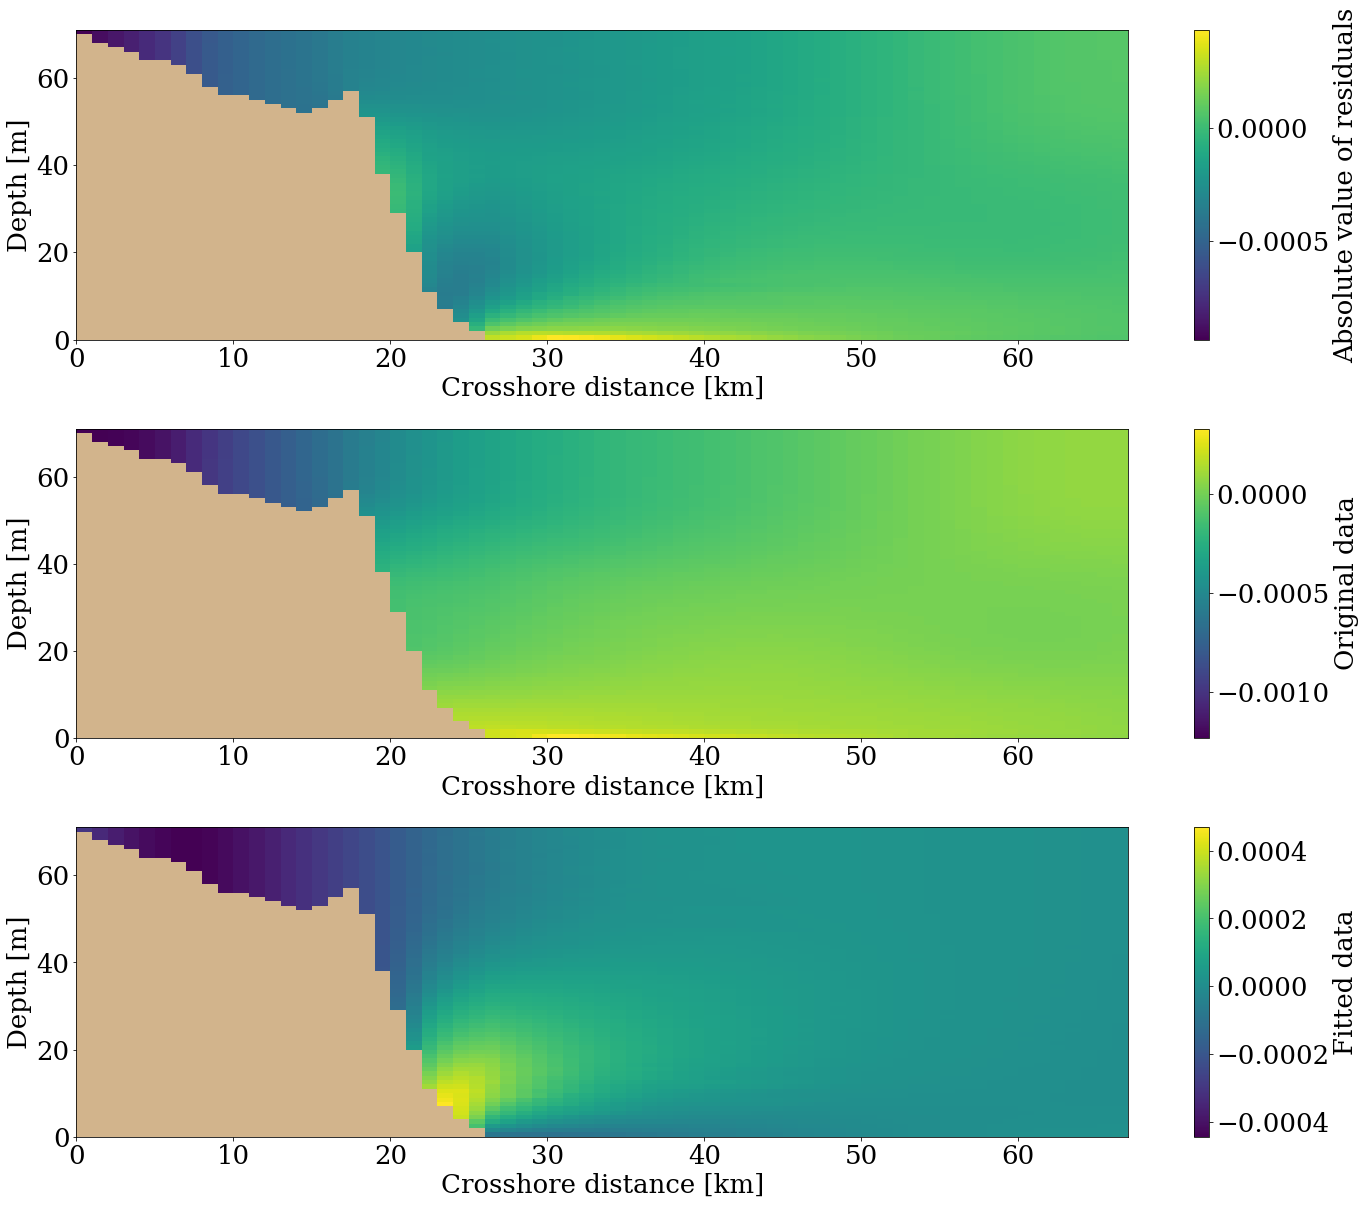

In [167]:
fig,ax=plt.subplots(3)
xlab='Crosshore distance [km]'
ylab='Depth [m]'

ax[0].set_facecolor('tan')
c=ax[0].pcolormesh(np.ma.masked_array(VALmit[t,:,:]-VALfit[t,:,:],mask=masky[:,indlon]))
cbar=plt.colorbar(c,ax=ax[0])
ax[0].set(xlabel=xlab, ylabel=ylab)
cbar.set_label('Absolute value of residuals')

ax[1].set_facecolor('tan')
c1=ax[1].pcolormesh(np.ma.masked_array(VALmit[t,:,:],mask=masky[:,indlon]))
cbar1=plt.colorbar(c1,ax=ax[1])
ax[1].set(xlabel=xlab, ylabel=ylab)
cbar1.set_label('Original data')

ax[2].set_facecolor('tan')
c2=ax[2].pcolormesh(np.ma.masked_array(VALfit[t,:,:],mask=masky[:,indlon]))
cbar2=plt.colorbar(c2,ax=ax[2])
ax[2].set(xlabel=xlab, ylabel=ylab)
cbar2.set_label('Fitted data')

#fig.suptitle(f'RMSE= {RMSE[t]}')

fig.tight_layout()

## Probability density function

In [11]:
params = {'font.size': 26,
          'figure.figsize': (15, 10),
         'font.family':'serif'}
pl.rcParams.update(params)

In [66]:
Ypre=VALmit[t,:,:].values
yhat=VALfit[t,:,:]


In [67]:
var=np.var(Ypre-yhat)
distr=(1/(np.sqrt(var)*np.sqrt(2*np.pi)))*np.exp(-(1/2)*(((Ypre-yhat)-np.mean(Ypre-yhat))/np.sqrt(var))**2)

In [68]:
np.std(Ypre-yhat)

0.00027657454515018

In [72]:
np.argmax((Ypre-yhat))

2231

ValueError: x and y must be the same size

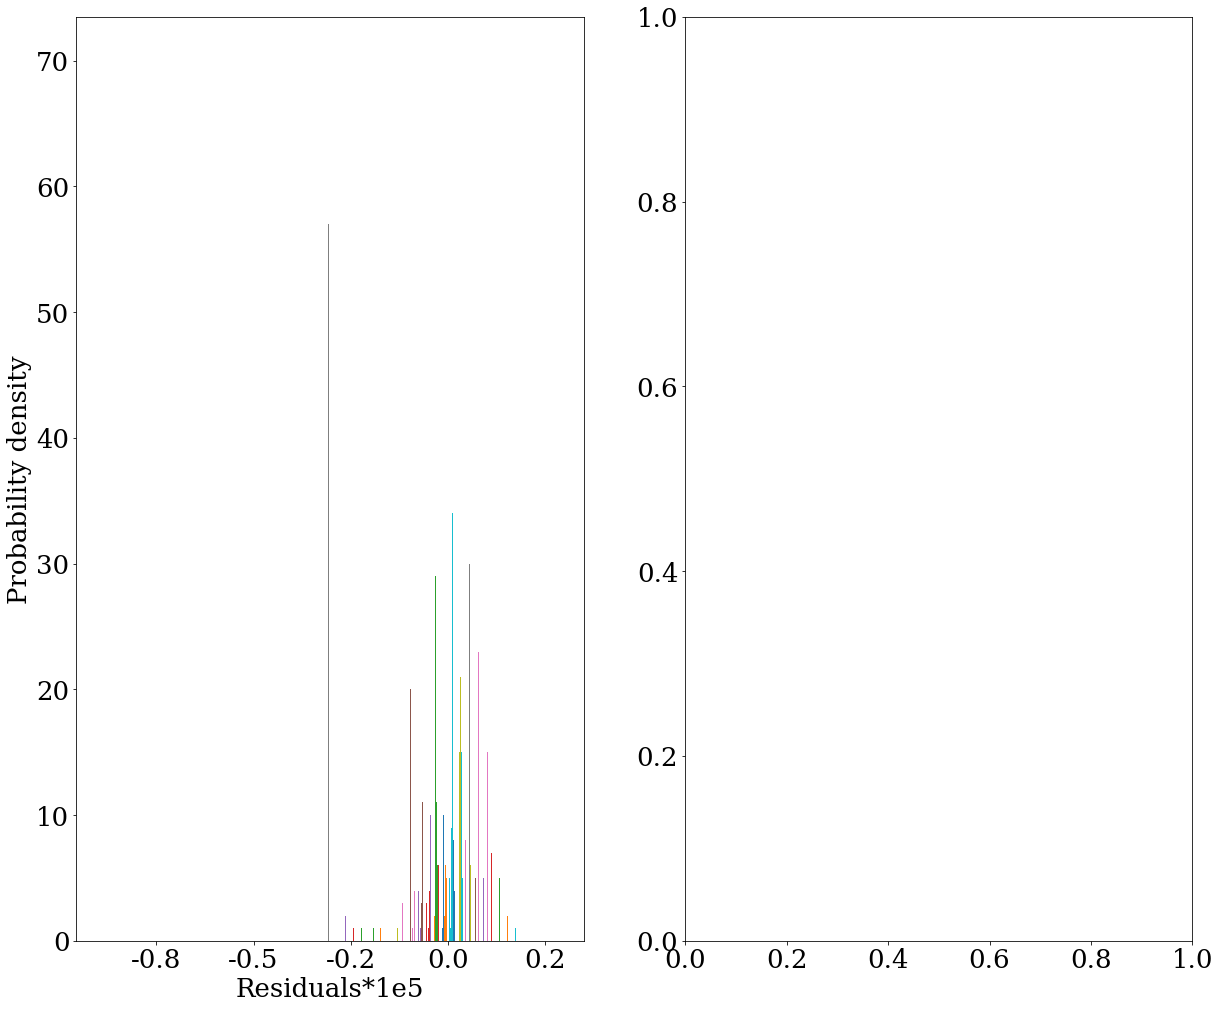

In [73]:
fig,ax=plt.subplots(1,2)
ax[0].hist((Ypre-yhat)*1e3,'auto')
ax[0].set(xlabel='Residuals*1e5',ylabel='Probability density')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[1].scatter(np.sort(Ypre-yhat)*1e3,np.arange(0,len(Ypre),1))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].set(xlabel='Residuals*1e5')

fig.tight_layout()

## Compare different P matrices

In [34]:
dsbetas=xr.open_dataset('WRLinReg3084FILTWweightfromOLS.nc')
ds1e9=xr.open_dataset('WRLinReg3084FILT.nc')
ds1e8=xr.open_dataset('WRLinReg3084FILT1e8.nc')
ds1=xr.open_dataset('WRLinReg3084FILTMode1x2.nc')
ds2=xr.open_dataset('WRLinReg3084FILTMode2x2.nc')
ds3=xr.open_dataset('WRLinReg3084FILTMode3x2.nc')
ds4=xr.open_dataset('WRLinReg3084FILTMode4x2.nc')
dsOLS=xr.open_dataset('LinReg3084FILT.nc')

In [47]:
indshort=np.arange(0,len(ds1.valfit[:,1,1]),10)

In [48]:
beta1=ds1.betas[indshort].values
beta2=ds2.betas[indshort].values
beta3=ds3.betas[indshort].values
beta4=ds4.betas[indshort].values
beta1e8=ds1e8.betas[indshort].values
beta1e9=ds1e9.betas[indshort].values
betaOLS=dsOLS.betas[indshort].values
betabeta=dsbetas.betas[indshort].values

In [49]:
rmse1=ds1.rmse[indshort].values
rmse2=ds2.rmse[indshort].values
rmse3=ds3.rmse[indshort].values
rmse4=ds4.rmse[indshort].values
rmse1e8=ds1e8.rmse[indshort].values
rmse1e9=ds1e9.rmse[indshort].values
rmseOLS=dsOLS.rmse[indshort].values
rmsermse=dsbetas.rmse[indshort].values

In [50]:
DOMmode1=np.zeros(len(beta1[:,1]))
DOMmode2=np.zeros(len(beta1[:,1]))
DOMmode3=np.zeros(len(beta1[:,1]))
DOMmode4=np.zeros(len(beta1[:,1]))
DOMmode1e8=np.zeros(len(beta1[:,1]))
DOMmode1e9=np.zeros(len(beta1[:,1]))
DOMmodeOLS=np.zeros(len(beta1[:,1]))
DOMmodebeta=np.zeros(len(beta1[:,1]))

for l in np.arange(len(beta1[:,1])):
    DOMmode1[l]=np.argmax(beta1[l,:])
    DOMmode2[l]=np.argmax(beta2[l,:])
    DOMmode3[l]=np.argmax(beta3[l,:])
    DOMmode4[l]=np.argmax(beta4[l,:])
    DOMmode1e8[l]=np.argmax(beta1e8[l,:])
    DOMmode1e9[l]=np.argmax(beta1e9[l,:])
    DOMmodeOLS[l]=np.argmax(betaOLS[l,:])
    DOMmodebeta[l]=np.argmax(betabeta[l,:])
    

[Text(0.5, 0, 'Time (hrs)'), Text(0, 0.5, 'Mode nr')]

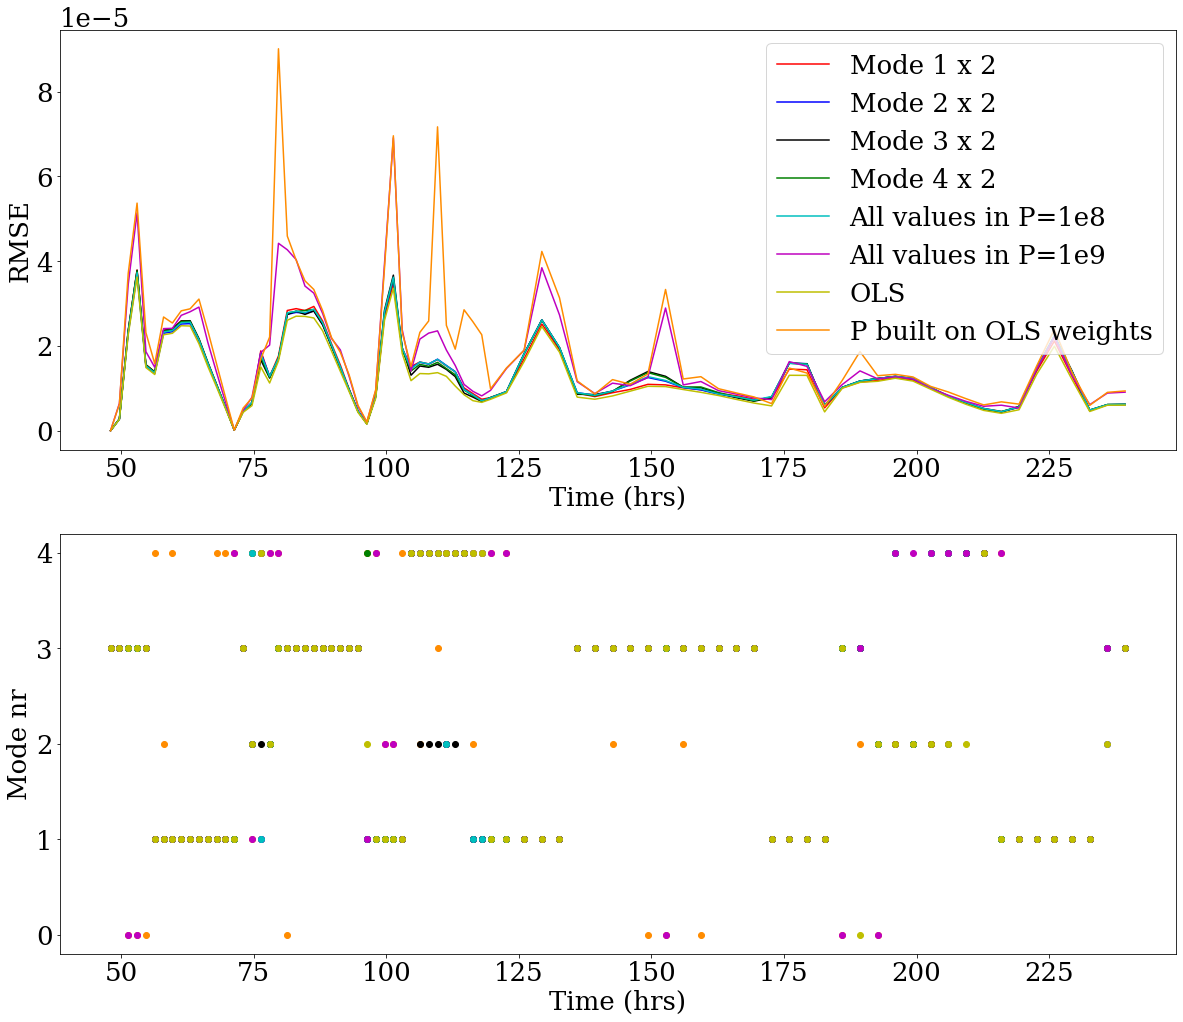

In [60]:
fig,ax=plt.subplots(2)
ax[0].plot(times[indshort]/60,rmse1,color='r',label=f'Mode 1 x 2, mean: {np.mean(rmse1):.2e}')
ax[0].plot(times[indshort]/60,rmse2,color='b',label=f'Mode 2 x 2, mean: {np.mean(rmse2):.2e}')
ax[0].plot(times[indshort]/60,rmse3,color='k',label=f'Mode 3 x 2, mean: {np.mean(rmse3):.2e}')
ax[0].plot(times[indshort]/60,rmse4,color='g',label=f'Mode 4 x 2, mean: {np.mean(rmse4):.2e}')
ax[0].plot(times[indshort]/60,rmse1e8,color='c',label=f'All values in P=1e8, mean: {np.mean(rmse1e8):.2e}')
ax[0].plot(times[indshort]/60,rmse1e9,color='m',label=f'All values in P=1e9, mean: {np.mean(rmse1e9):.2e}')
ax[0].plot(times[indshort]/60,rmseOLS,color='y',label=f'OLS, mean: {np.mean(rmseOLS):.2e}')
ax[0].plot(times[indshort]/60,rmsermse,color='darkorange',label=f'P built on OLS weights, mean: {np.mean(rmsermse):.2e}')

ax[0].set(xlabel='Time (hrs)', ylabel='RMSE')
#ax[0].annotate(f'{RMSE[0]:.2e}',(times[0]/60,RMSE[0]))
#ax[0].annotate(f'{RMSEp[0]:.2e}',(times[0]/60,RMSEp[0]))
#ax[0].annotate(f'{RMSE[-1]:.2e}',(times[-1]/60,RMSE[0]))
#ax[0].annotate(f'{RMSEp[-1]:.2e}',(times[-1]/60,RMSEp[0]))
#ax[0].annotate(f'{dsPsam.rmse.values[0]:.2e}',(times[0]/60,dsPsam.rmse.values[0]))
#ax[0].annotate(f'{dsPsam.rmse.values[-1]:.2e}',(times[-1]/60,dsPsam.rmse.values[0]))
#ax[0].set_ylim([0,0.00015])

ax[0].legend()
ax[1].plot(times[indshort]/60,DOMmode1,'ro',label='Dominating mode mode 1x2')
ax[1].plot(times[indshort]/60,DOMmode2,'bo',label='Dominating mode mode 2x2')
ax[1].plot(times[indshort]/60,DOMmode3,'ko',label='Dominating mode mode 3x2')
ax[1].plot(times[indshort]/60,DOMmode4,'go',label='Dominating mode mode 4x2')
ax[1].plot(times[indshort]/60, DOMmode1e8,'co',label='Dominating mode with P being 1e8')
ax[1].plot(times[indshort]/60, DOMmode1e9,'mo',label='Dominating mode with P being 1e9')
ax[1].plot(times[indshort]/60, DOMmodeOLS,'yo',label='Dominating mode from OLS')
ax[1].scatter(times[indshort]/60, DOMmodebeta,color='darkorange',label='Dominating mode with OLS weights in P')
ax[1].set(xlabel='Time (hrs)', ylabel='Mode nr')
#ax[1].legend()

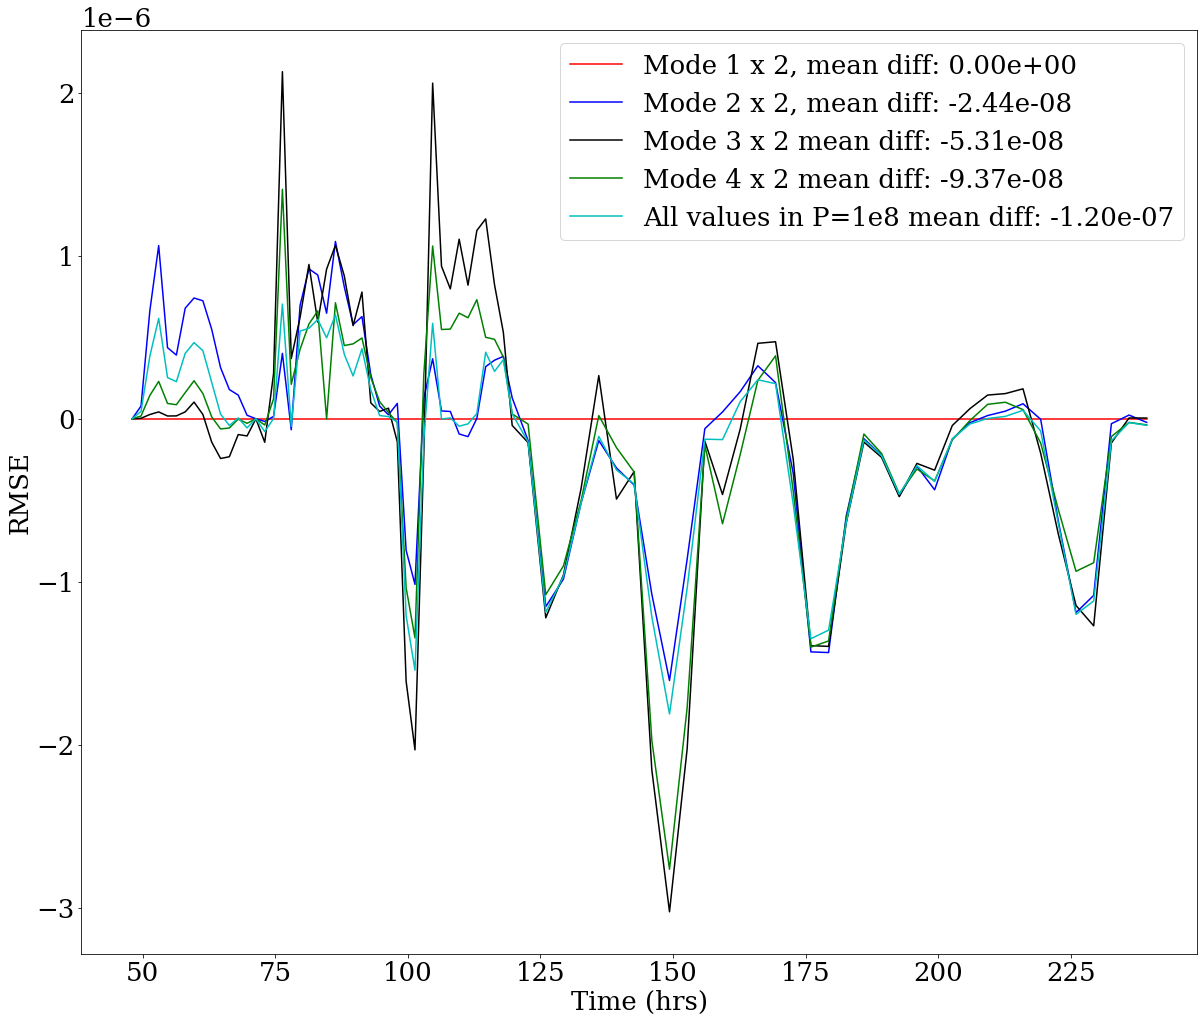

In [83]:
RMSEminus=rmse1
fig,ax=plt.subplots()
ax.plot(times[indshort]/60,RMSEminus-rmse1,color='r',label=f'Mode 1 x 2, mean diff: {np.mean(RMSEminus-rmse1):.2e}')
ax.plot(times[indshort]/60,RMSEminus-rmse2,color='b',label=f'Mode 2 x 2, mean diff: {np.mean(RMSEminus-rmse2):.2e}')
ax.plot(times[indshort]/60,RMSEminus-rmse3,color='k',label=f'Mode 3 x 2 mean diff: {np.mean(RMSEminus-rmse3):.2e}')
ax.plot(times[indshort]/60,RMSEminus-rmse4,color='g',label=f'Mode 4 x 2 mean diff: {np.mean(RMSEminus-rmse4):.2e}')
ax.plot(times[indshort]/60,RMSEminus-rmse1e8,color='c',label=f'All values in P=1e8 mean diff: {np.mean(RMSEminus-rmse1e8):.2e}')
#ax.plot(times[indshort]/60,RMSEminus-rmse1e9,color='m',label='All values in P=1e9')
#ax.plot(times[indshort]/60,RMSEminus-rmseOLS,color='y',label='OLS')
#ax.plot(times[indshort]/60,RMSEminus-rmsermse,color='darkorange',label='P built on OLS weights')

ax.set(xlabel='Time (hrs)', ylabel='RMSE')
ax.legend()

## Comparing filtered values to unfiltered

In [10]:
dsFILT=xr.open_dataset('WRLinReg3084FILT1e8.nc')
dsUNFILT=xr.open_dataset('WRLinReg3084.nc')
dslrnFILT=xr.open_dataset('LinReg3084.nc')

In [41]:
betafilt=dsFILT.betas.values
betaunfilt=dsUNFILT.betas.values
betalrnfilt=dslrnFILT.betas.values
rmsefilt=dsFILT.rmse.values
rmseunfilt=dsUNFILT.rmse.values
rmselrnfilt=dslrnFILT.rmse.values

In [42]:
DOMmodeunfilt=np.zeros(len(betafilt[:,1]))
DOMmodefilt=np.zeros(len(betafilt[:,1]))
DOMmodelrnfilt=np.zeros(len(betafilt[:,1]))
for l in np.arange(len(betafilt[:,1])):
    DOMmodeunfilt[l]=np.argmax(betaunfilt[l,:])
    DOMmodefilt[l]=np.argmax(betafilt[l,:])
    DOMmodelrnfilt[l]=np.argmax(betalrnfilt[l,:])

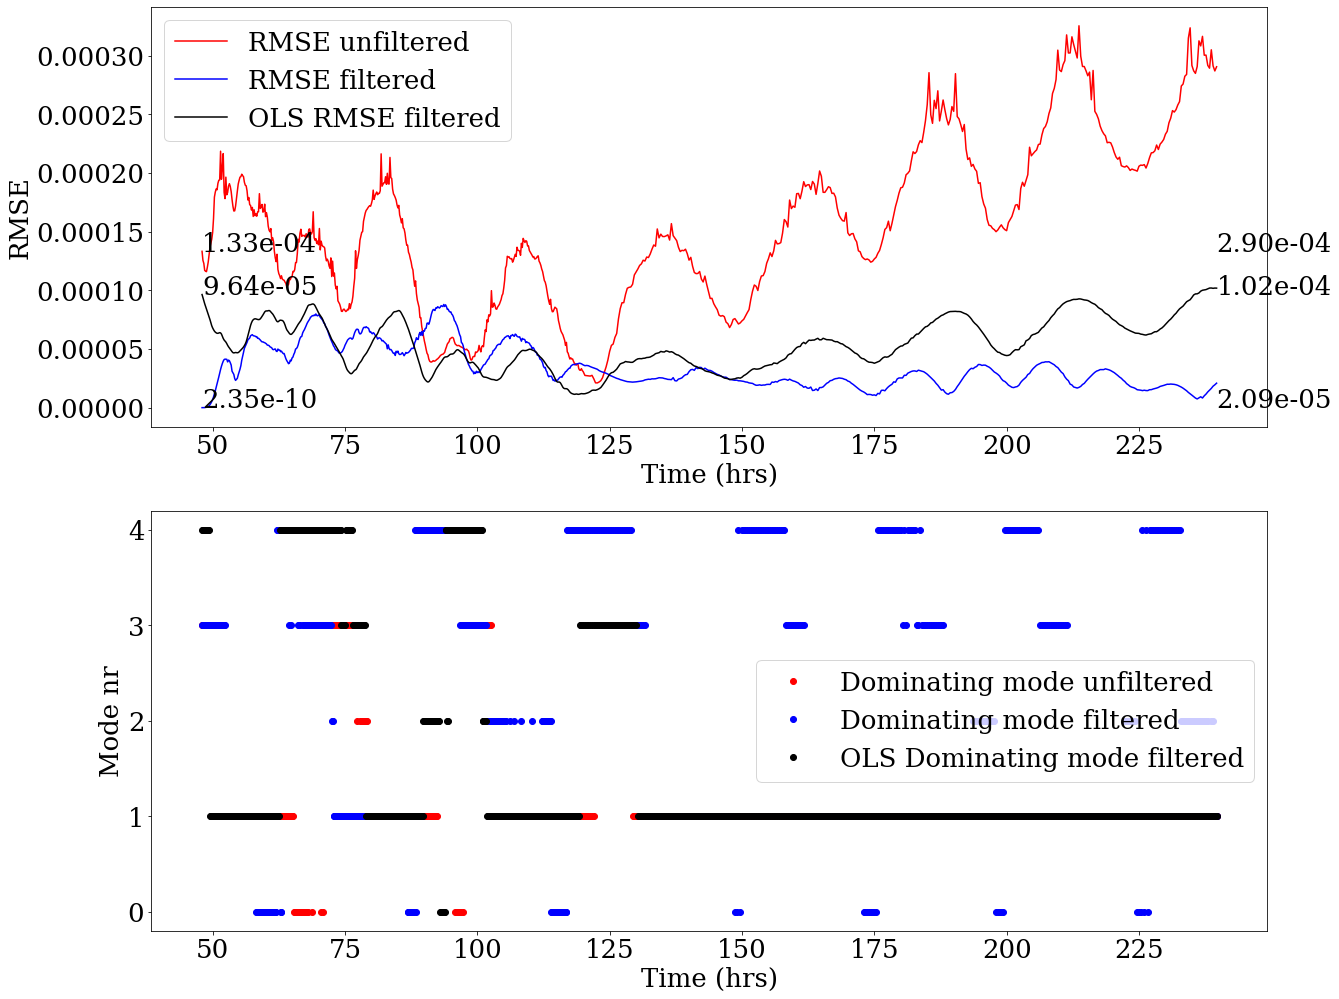

In [46]:
fig,ax=plt.subplots(2)
ax[0].plot(times/60,rmseunfilt,color='r',label='RMSE unfiltered')
ax[0].plot(times/60,rmsefilt,color='b',label='RMSE filtered')
ax[0].plot(times/60,rmselrnfilt,color='k',label='OLS RMSE filtered')
ax[0].set(xlabel='Time (hrs)', ylabel='RMSE')
ax[0].annotate(f'{rmsefilt[0]:.2e}',(times[0]/60,rmsefilt[0]))
ax[0].annotate(f'{rmseunfilt[0]:.2e}',(times[0]/60,rmseunfilt[0]))
ax[0].annotate(f'{rmsefilt[-1]:.2e}',(times[-1]/60,rmsefilt[0]))
ax[0].annotate(f'{rmseunfilt[-1]:.2e}',(times[-1]/60,rmseunfilt[0]))
ax[0].annotate(f'{rmselrnfilt[0]:.2e}',(times[0]/60,rmselrnfilt[0]))
ax[0].annotate(f'{rmselrnfilt[-1]:.2e}',(times[-1]/60,rmselrnfilt[0]))

ax[0].legend()
ax[1].plot(times/60,DOMmodeunfilt,'or',label='Dominating mode unfiltered')
ax[1].plot(times/60, DOMmodefilt,'ob',label='Dominating mode filtered')
ax[1].plot(times/60, DOMmodelrnfilt,'ok',label='OLS Dominating mode filtered')
ax[1].set(xlabel='Time (hrs)', ylabel='Mode nr')
ax[1].legend()

## Saving the regression values

In [103]:
FILENAME='WRLinReg3084.nc'
ds = xr.Dataset({'valfit': (("time","z","x"), VALFITp),
                 'valmit': (("time","z","x"), VALMITp),
                 'varbrink1': (("z","x"), varbrink1),
                 'varbrink2': (("z","x"), varbrink2),
                 'varbrink3': (("z","x"), varbrink3),
                 'varbrink4': (("z","x"), varbrink4),
                 'fit':(("time"), FITp),
                 'gridX':(("z","x"), grid_X),
                 'gridZ':(("z","x"), grid_Z),
                 'betas':(("time","nrB"), BETAp),
                 'rmse':(("time"), RMSEp)
                    },
                coords ={
                    "x" : dist.values,
                    "z" : Z,
                    "time": times,
                    "nrB": np.arange(0,5,1)
                },
                )
ds.to_netcdf(FILENAME)

In [82]:
FILENAME='WRLinReg3084FILTR1.nc'
ds = xr.Dataset({'valfit': (("time","z","x"), VALfit),
                 'valmit': (("time","z","x"), VALmit),
                 'varbrink1': (("z","x"), varbrink1),
                 'varbrink2': (("z","x"), varbrink2),
                 'varbrink3': (("z","x"), varbrink3),
                 'varbrink4': (("z","x"), varbrink4),
                 'fit':(("time"), fit),
                 'gridX':(("z","x"), grid_X),
                 'gridZ':(("z","x"), grid_Z),
                 'betas':(("time","nrB"), betas),
                 'rmse':(("time"), RMSE)
                    },
                coords ={
                    "x" : dist.values,
                    "z" : Z,
                    "time": times,
                    "nrB": np.arange(0,5,1)
                },
                )
ds.to_netcdf(FILENAME)

# Pressure

### At 30.84 degrees north

##### How is the fit? 

In [21]:
ds = xr.open_dataset('LinReg3084.nc')

In [22]:
VALMITp=ds.valmit
VALFITp=ds.valfit
varbrink1=ds.varbrink1
varbrink2=ds.varbrink2
varbrink3=ds.varbrink3
varbrink4=ds.varbrink4
BETAp=ds.betas.values
FITp=ds.fit.values
grid_Z=ds.gridZ
grid_X=ds.gridX
dist=ds.x
Z=ds.z
TIME=ds.time.values

TypeError: LINREGplot() missing 1 required positional argument: 'rmse'

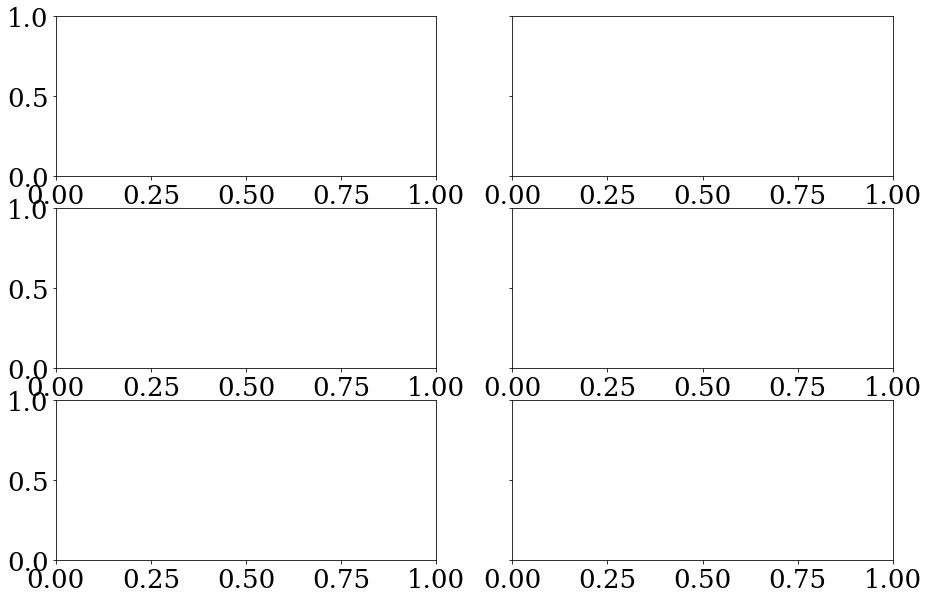

In [23]:
ind=lat_ac[58]
lat=30.84
t=500
fig,ax = plt.subplots(3,2,sharey=True)
LINREGplot(fig,ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1],VALMITp,VALFITp,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,TIME,BETAp,FITp,t)

### At 31.20 degrees north

##### How is the fit? 

In [60]:
ds = xr.open_dataset('LinReg312.nc')

In [61]:
VALMITp=ds.valmit
VALFITp=ds.valfit
varbrink1=ds.varbrink1
varbrink2=ds.varbrink2
varbrink3=ds.varbrink3
varbrink4=ds.varbrink4
BETAp=ds.betas.values
FITp=ds.fit.values
grid_Z=ds.gridZ
grid_X=ds.gridX
dist=ds.x
Z=ds.z
TIME=ds.time.values

In [62]:
np.mean(FITp)

91.95123177596902

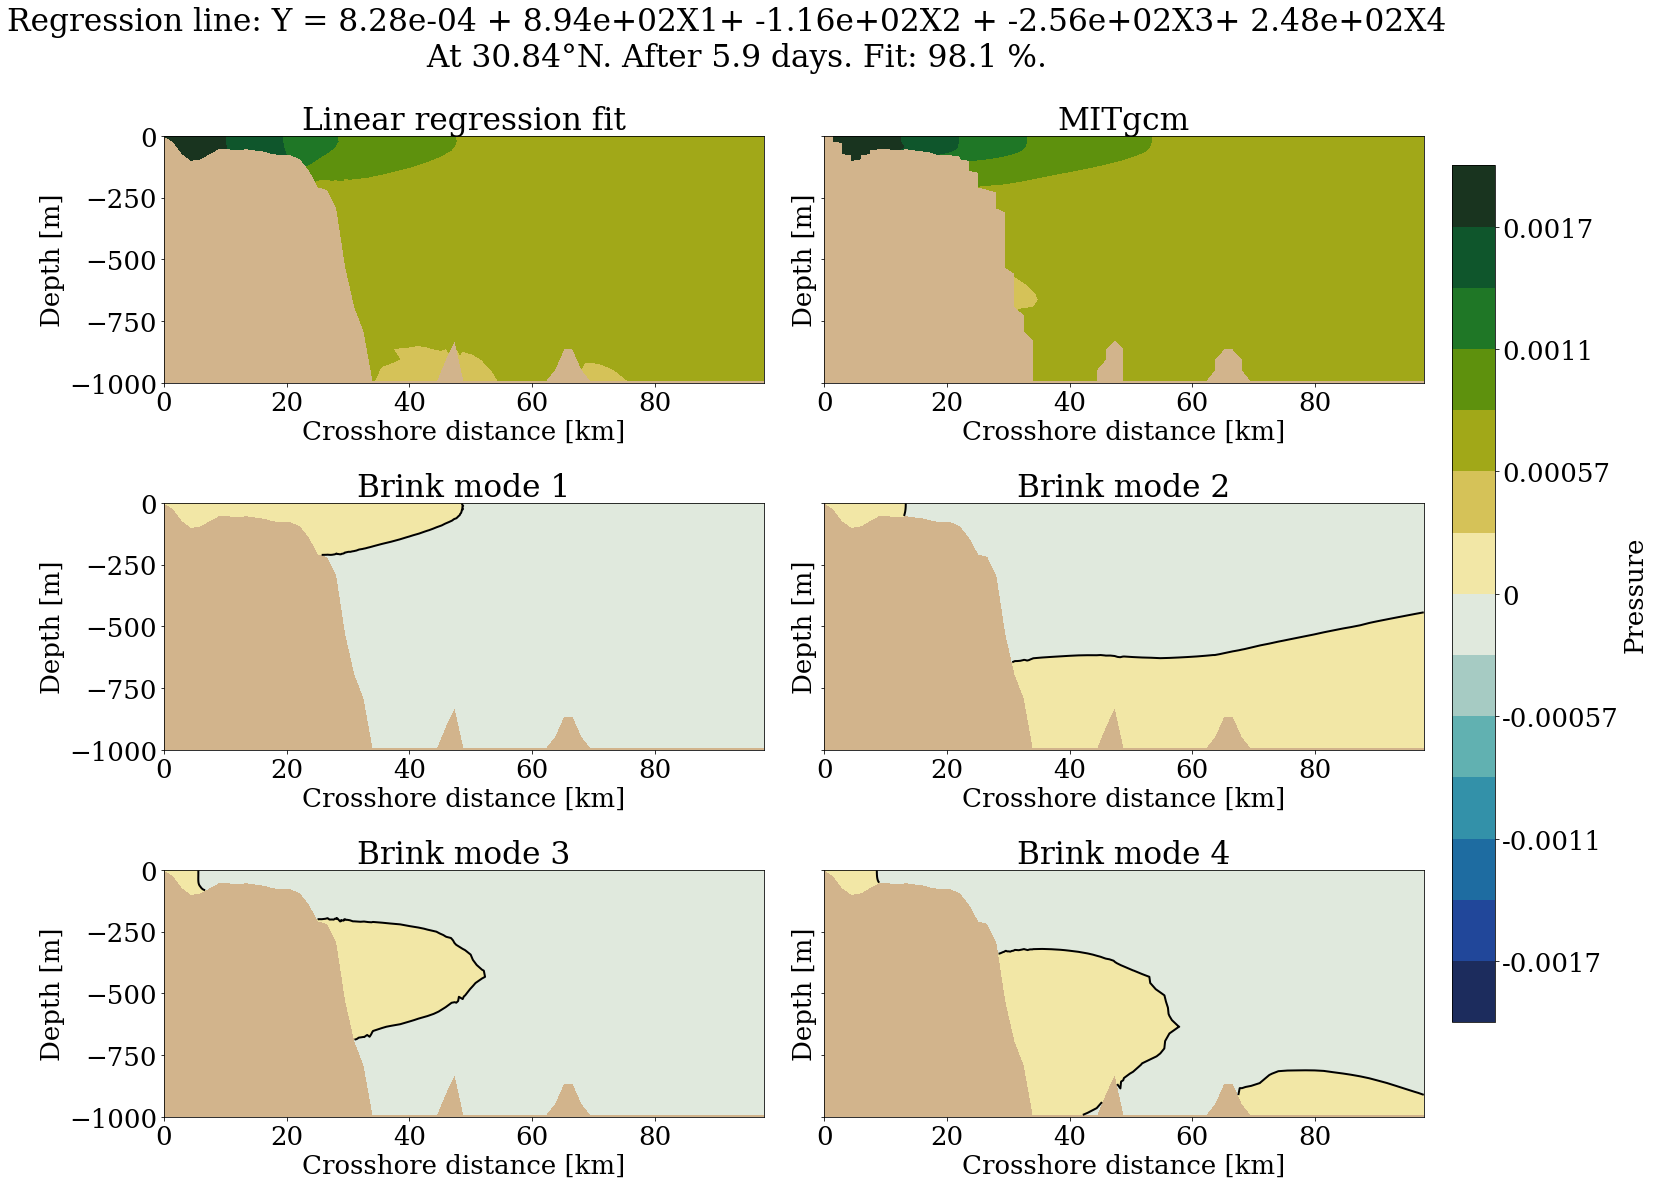

In [63]:
ind=lat_ac[85]
lat=31.2
t=500
fig,ax = plt.subplots(3,2,sharey=True)
LINREGplot(fig,ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1],VALMITp,VALFITp,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,TIME,BETAp,FITp,t)

### At 32.68 degrees north

##### How is the fit? 

In [64]:
ds = xr.open_dataset('LinReg3268.nc')

In [65]:
VALMITp=ds.valmit
VALFITp=ds.valfit
varbrink1=ds.varbrink1
varbrink2=ds.varbrink2
varbrink3=ds.varbrink3
varbrink4=ds.varbrink4
BETAp=ds.betas.values
FITp=ds.fit.values
grid_Z=ds.gridZ
grid_X=ds.gridX
dist=ds.x
Z=ds.z
TIME=ds.time.values

In [66]:
np.mean(FITp)

87.74958776944918

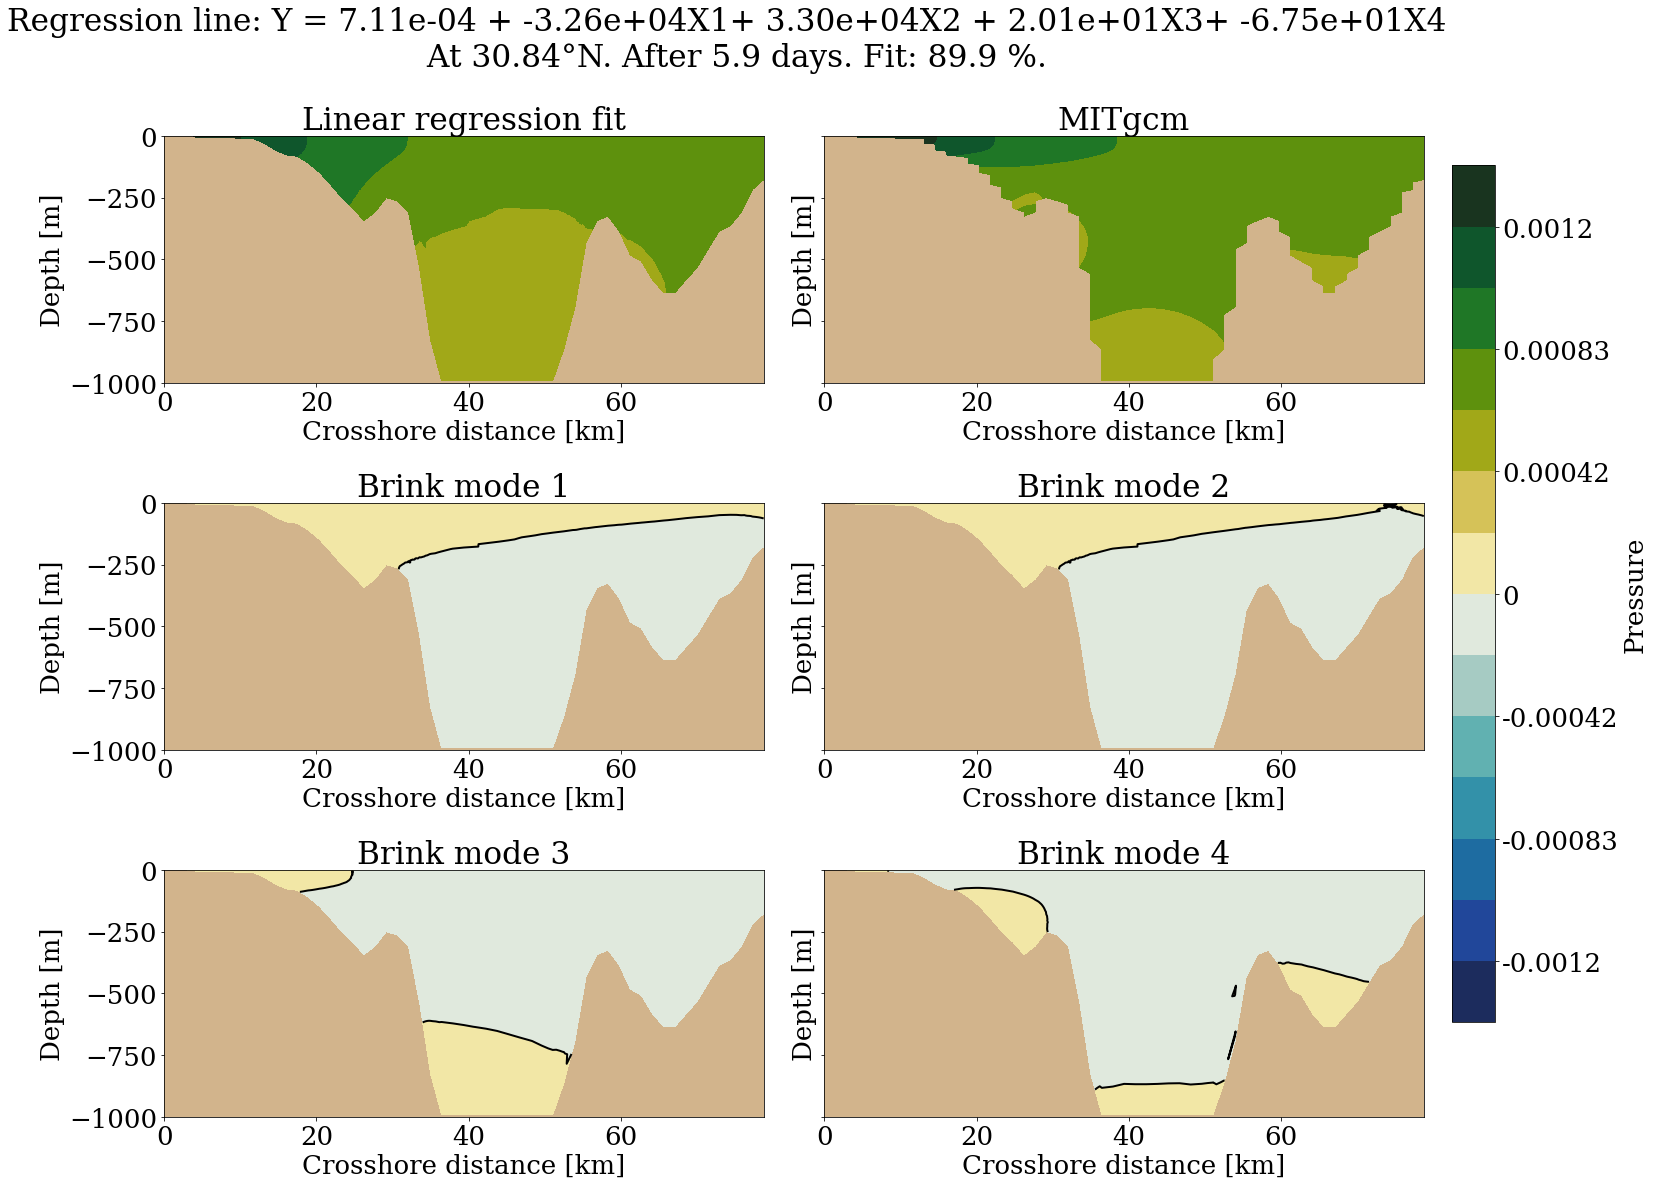

In [67]:
ind=lat_ac[205]
lat=32.68
t=500
fig,ax = plt.subplots(3,2,sharey=True)
LINREGplot(fig,ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1],VALMITp,VALFITp,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,TIME,BETAp,FITp,t)

### At 32.98 degrees north

##### How is the fit? 

In [68]:
ds = xr.open_dataset('LinReg3298.nc')

In [69]:
VALMITp=ds.valmit
VALFITp=ds.valfit
varbrink1=ds.varbrink1
varbrink2=ds.varbrink2
varbrink3=ds.varbrink3
varbrink4=ds.varbrink4
BETAp=ds.betas.values
FITp=ds.fit.values
grid_Z=ds.gridZ
grid_X=ds.gridX
dist=ds.x
Z=ds.z
TIME=ds.time.values

In [70]:
np.mean(FITp)

83.77281850995483

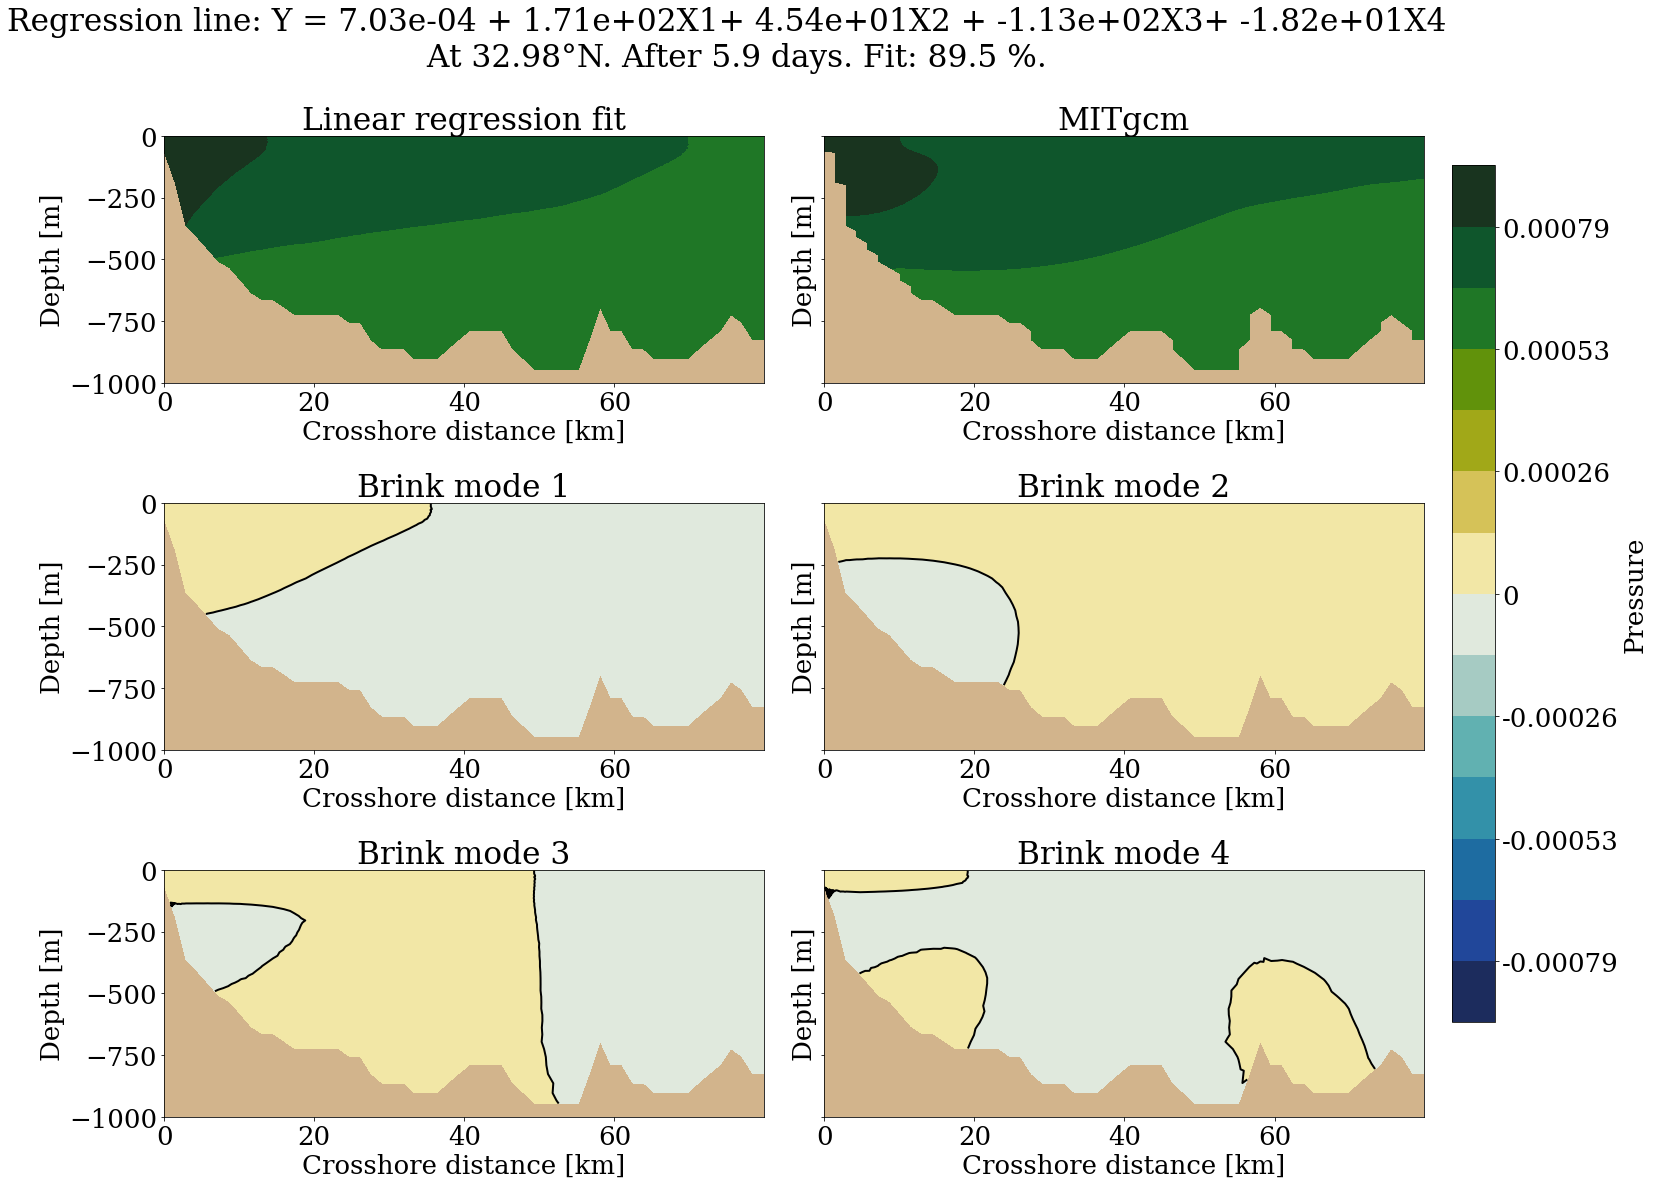

In [73]:
ind=lat_ac[227]
lat=32.98
t=500
fig,ax = plt.subplots(3,2,sharey=True)
LINREGplot(fig,ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1],VALMITp,VALFITp,varbrink1,varbrink2,varbrink3,varbrink4,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,TIME,BETAp,FITp,t)

In [35]:
# RMAKE
def R_MAKE(Y,X,VALmit,Ypre,zpi,xpi,typ,t):
    # 
    # Accessory function to red_tide. This builds the R matrix.
    # 
    # INPUT:    IN = vector, either a spectrum if "Format" is one of 's',
    #                'spec', or 'spectrum', or an (auto)covariance if "Format"
    #                is one of 'c', 'cov', 'covariance'.
    #                - If "IN" is a spectrum, it is assumed that IN(end)
    #                corresponds to the Nyquist frequency and IN(1) corresponds
    #                to the fundamental frequency, with spacing = df = 1/T,
    #                both in units of 1/hour, and where T > Cov_cutoff.
    #                - If "IN" is an autocovariance, it is assumed that IN(1)
    #                corresponds to zero lag (i.e. variance), and that each
    #                successive element corresponds to one additional time lag
    #                equal to the time step of the time series being analyzed.
    # 
    #           N = the dimension of R, whch will be NxN
    # 
    #           Format = string, see above for accepted values in "IN".
    # 
    # OUTPUT:   R = The R-matrix (error covariance) to be used in red_tide
    # 
    #           freq = (OPTIONAL) frequency vector corresponding to S_R below.
    #                Note that here, df = 1/(2N) [because double the
    #                autocovariance is used to build the spectrum] and
    #                freq(end) = 0.5. That is, the units of "freq" are not
    #                1/hours but rather 1/(dt/hour).
    #                E.g. if dt = 1/3 hours, then multiply "freq" by 3/hour to
    #                put it in units of 1/hour.
    # 
    #           S_R = (OPTIONAL) spectrum of a process with the covariance of
    #                a column of R. This is what red_tide actually "sees" for
    #                model covariance in the spectral domain when it's
    #                estimating model coefficients.
    ds = xr.open_dataset('LinReg3084.nc')
    Yfit=ds.valfit[t,:,:].values

    normR=(VALmit-Yfit)-np.mean(VALmit-Yfit)
    
    K = np.shape(normR)

    Rfft = scipy.fft.fft2(normR, s=(2*K[0],K[1]*2))
    
    #Format cov
    #Format='c'
    #acf = np.real( scipy.fft.ifft2( (Rfft * np.conjugate(Rfft) ))[:K[0],:K[1]] )

    #acf = sum(sum(np.real(Rfft)))*(acf/(K[0]*K[1]))/acf[0,0]
    #IN=acf[zpi,xpi]
    
    #Format spect
    Format='spectrum'
    #Rfft=Rfft[zpi,xpi]
   
    IN = np.abs(Rfft) ** 2
    
    if typ == 'white':
        ds = xr.open_dataset('LinReg3084.nc')
        betas=ds.betas[t,:]
        N=len(Y)
        Yfit=X.dot(betas) + np.mean(Ypre)
        
        normR=(Y-Yfit)-np.mean(Y-Yfit)
        sigmaS= np.mean(np.matmul(normR.T,normR))/N
        R=sigmaS*np.identity(N)
        Rfft=0
        RfftF=0
        
    elif typ == 'widesense':
        N=len(IN)
        if Format =='s' or Format =='spec' or Format =='spectrum':
            Cov_cutoff=np.shape(IN)
            #S = np.insert(IN,0,0) # 0 for zero mean, because fft treats the first element as zero frequency
            SS = np.concatenate((S, np.flip(S[1:-1])))
            fSS = scipy.fft.ifft(SS)/len(SS)
            rmsr = sqrt(np.mean(np.real(fSS)**2))
            rmsi = sqrt(np.mean(np.imag(fSS)**2))
            if rmsr < 10000*rmsi:
                raise ValueError('Non-trivial imaginary component to the Fourier transform of the given spectrum.')
            else:
                fSS = np.real(fSS)
            
            C=fSS[:Cov_cutoff]
            C = sum(S)*C/C[0]
            R = scipy.sparse.diags(ml.repmat(np.concatenate((np.flip(C[1:]),C)),N,1).T,np.arange(1-len(C),len(C),1),shape=(N,N)).toarray()
            
        elif Format =='c' or Format =='cov' or Format =='covariance':
             R = scipy.sparse.diags(ml.repmat(np.concatenate((np.flip(IN[1:]),IN)),N,1).T,np.arange(1-len(IN),len(IN),1),shape=(N,N)).toarray()
                            
        else:
            error('Invalid second input "Format".')

    return R, Rfft,IN
